In [5]:
import numpy as np
import pandas as pd 

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error as mse

from PIL import Image, ImageEnhance,UnidentifiedImageError

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
sns.set_theme(style='ticks')
import os

# for issues downloading files from Kaggle output
from IPython.display import FileLink

# shut up
import warnings
warnings.filterwarnings('ignore')

# Section 1: Data Processing


## Get Array of Image Data

In [6]:
# Only using a few pokemon from the dataset
poke_labels = ['Abra', 'Krabby', 'Bulbasaur', 'Charmander', 'Squirtle', 'Pikachu', 'Eevee', 'Porygon', 'Ditto', 'Snorlax','Voltorb', 'Poliwag', 'Chansey', 'Meowth']

poke_labels.sort()

num_classes = len(poke_labels)
for i in range(num_classes):
    print(i, ': ', poke_labels[i])

0 :  Abra
1 :  Bulbasaur
2 :  Chansey
3 :  Charmander
4 :  Ditto
5 :  Eevee
6 :  Krabby
7 :  Meowth
8 :  Pikachu
9 :  Poliwag
10 :  Porygon
11 :  Snorlax
12 :  Squirtle
13 :  Voltorb


In [7]:
# First run of code will process data and store it into the processed_data.csv
# on any further runs (or when processed_data.csv exists on the path), just read the csv

dataPath = 'processed_data.csv'
try:
    data = np.genfromtxt(dataPath, delimiter=',')
    X_full = data[:,:data.shape[1]-1]
    y_full = data[:, -1:]

except OSError:
    folderPath = 'PokemonData'

    X_lst = []
    y_lst = []

    for target in range(len(poke_labels)):
        pokemon = poke_labels[target]
        pokemonPath = folderPath + '/' + pokemon
        for image in os.listdir(pokemonPath):
            imagePath = pokemonPath + '/' + image
            try:
                img = Image.open(imagePath) # full color
                img_formatted = img.convert('HSV').resize((40,40)) # (40,40,3), 3 HSV color values per pixel
                img_array = np.array(img_formatted).flatten() # flatten into 40*40*3 array of features
                X_lst.append(img_array)
                y_lst.append([target])
            except UnidentifiedImageError: 
                # skip the image if it's type is incompatible with pillow
    #             print('Skipped:' + imagePath )
                pass
    
    X_full = np.vstack(X_lst)
    y_full = np.array(y_lst)
    np.savetxt(dataPath, np.hstack((X_full, y_full)), delimiter=',')


In [8]:
FileLink(dataPath)

C:\Users\melis\Documents\School\Machine Learning\Project\processed_data.csv

In [9]:
X = X_full.astype('float16')
y = y_full.astype('float16')
print(X.shape)
print(y.shape)

(646, 4800)
(646, 1)


In [10]:
feature_labels = []
for i in range(X.shape[1]):
    if (i%3 == 0): color = 'R'
    if (i%3 == 1): color = 'G'
    if (i%3 == 2): color = 'B'

    feature_labels.append(color + str(i//3))
    
pokemon_col = np.array(poke_labels)[:,np.newaxis]

## Data Pre-Processing

In [11]:
def scale_split_data(X,y, scaling='none'):
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, stratify=y, train_size=0.8, random_state=74)
    if scaling == 'none':
        X_tr_scale = X_tr
        X_ts_scale = X_ts
    else:
        if scaling == 'standard':
            scaler = preprocessing.StandardScaler()
        elif scaling == 'minmax':
            scaler = preprocessing.MinMaxScaler()
        X_tr_scale = scaler.fit_transform(X_tr)
        X_ts_scale = scaler.fit_transform(X_ts)

    return X_tr_scale, X_ts_scale, y_tr, y_ts

In [12]:
# information about what transforms to perform on images referenced from:
# https://towardsdatascience.com/augmentation-for-image-classification-24ffcbc38833

def transform_data(flip_vertical=False, rotate_deg=0, brightness_fact=1):
    X_transform = np.array(X)
    for i in range(X_transform.shape[0]): 
        cpy = X_transform[i,:].reshape(40,40,3)
        img = Image.fromarray(cpy.astype('uint8'), 'HSV')
        img = ImageEnhance.Brightness(img).enhance(brightness_fact)
        img = img.rotate(rotate_deg)
        if flip_vertical: img = img.transpose(method=Image.FLIP_LEFT_RIGHT)
        X_transform[i,:] = np.array(img).flatten()
    return X_transform

# Section 2: Logistic Regression
Code from HW 4 and HW 5 referenced

In [13]:
image_path = 'logreg'
try:
    os.mkdir(image_path)
except FileExistsError:
    pass

## Function to procees and display models of various lambdas

In [14]:
def run_all_logreg(X,y, scaling='standard', transform='no', max_iter=5000):
    X_train, X_test, y_train, y_test = scale_split_data(X, y, scaling=scaling)
    y_train_1d = y_train.reshape(y_train.size)
    y_test_1d = y_test.reshape(y_test.size)

    file_mod = transform
    title_mod = transform  + " transform"
    table_data = []
    table_row_labels=[]

    def run_logreg(penalty, solver='saga', c_val=1.0):
        logreg = LogisticRegression(penalty=penalty,solver=solver,class_weight='balanced', max_iter=max_iter, C=c_val) #multi_class='ovr'
        logreg.fit(X_train, y_train_1d)

        y_hat_train = logreg.predict(X_train)
        acc_train = logreg.score(X_train, y_train)

        y_hat_test = logreg.predict(X_test)
        acc_test = logreg.score(X_test,y_test)

        table_data.append([acc_train, acc_test, mse(y_train, y_hat_train), mse(y_test, y_hat_test)])

        if penalty == 'none': label = 'no regularization'
        else: label = penalty.upper() + ' regularization (c= {})'.format(c_val)
        table_row_labels.append(label)
        print('Train Metrics: Logistic Regression with '+label)
        print(metrics.classification_report(y_train, y_hat_train, target_names=poke_labels))
        print('Test Metrics: Logistic Regression with '+label)
        print(metrics.classification_report(y_test, y_hat_test, target_names=poke_labels))
        # heatmap from https://medium.com/swlh/logistic-regression-for-image-classification-e15d0ae59ce9
        cm = pd.crosstab(y_test_1d, y_hat_test, rownames=["True"], colnames=["predicted"], normalize='index')
        p = sns.heatmap(cm, annot=True, fmt=".1f")
        plt.show()

    c_vals = [10**i for i in range(-5,3)]
    run_logreg('l2',c_val=0.001)
    # # no penalty
    # run_logreg('none', solver='lbfgs')
    #
    # # L1 penalty
    # for c in c_vals:
    #     run_logreg('l1', c_val=c)
    # l1_end = len(table_data)
    #
    # # L2 penalty
    # for c in c_vals:
    #     run_logreg('l2', c_val=c)

    
  # plots
    array_data = np.array(table_data)      

    
    # Plot accuracy and MSE

    # fig, axs = plt.subplots(3,2, figsize=(15,15))
    # fig.suptitle("Accuracy and MSE for Logistsic Regression {}".format(title_mod))
    #
    # for row in range(axs.shape[0]):
    #     axs[row,0].set_ylabel("Accuracy")
    #     axs[row,1].set_ylabel("Mean Squared Error")
    #     if row == 0:
    #         for col in range(axs.shape[1]):
    #             axs[row,col].bar(['Train'], array_data[0, (col*2):(col*2)+1])
    #             axs[row,col].bar(['Test'], array_data[0, (col*2)+1:(col*2)+2])
    #
    #             axs[row,col].title.set_text('No penalty')
    #             axs[row,col].set_xlabel('value')
    #             axs[row,col].legend(['Train', 'Test'] )
    #     else:
    #         if row == 1: slc = slice(1,l1_end); title = 'L1 Penalty'
    #         else: slc = slice(l1_end,len(table_data)); title = 'L2 Penalty'
    #         for col in range(axs.shape[1]):
    #             axs[row,col].plot(c_vals, array_data[slc, col*2])
    #             axs[row,col].plot(c_vals, array_data[slc, col*2+1])
    #             axs[row,col].title.set_text(title)
    #             axs[row,col].set_xlabel('c')
    #             axs[row,col].legend(['Train', 'Test'] )
    #
    # fig.subplots_adjust( wspace=0.3,hspace=0.3,top=0.9, bottom=0.3)
    #
    # fig.savefig(image_path+"/logreg_acc_mse_{}.png".format(file_mod))
    # plt.show()
    # plt.clf()

## No transform

In [15]:
# run_all_logreg(X, y)

## Vertical flip transform

In [16]:
X_transform = transform_data(flip_vertical=True)
# run_all_logreg(X_transform, y, transform='vertical flip')

## 15 degree rotate transform

In [17]:
X_transform = transform_data(rotate_deg=15)
# run_all_logreg(X_transform, y, transform='15 degree rotate')

## Increase Brightness Transform

In [18]:
X_transform = transform_data(brightness_fact=1.5)
# run_all_logreg(X_transform, y, transform='increase brightness')

## Running all tests for standard scaling

# Section 3: SVM
Code from HW 5 referenced

In [19]:
image_path = 'SVM'
try:
    os.mkdir(image_path)
except FileExistsError:
    pass

## Function to procees and display SVM models with varying lambda

In [20]:
def svm_func(kernel, scaling='standard', max_iter=5000):
    X_train, X_test, y_train, y_test = scale_split_data(X, y, scaling=scaling)
    y_train_1d = y_train.reshape(y_train.size)
    y_test_1d = y_test.reshape(y_test.size)

    file_mod = kernel
    title_mod = kernel + ' kernel SVM'

    table_data = []
    table_row_labels=[]

    c_vals = [10**i for i in range(-5,3)]
    for c in c_vals:
        svc = SVC(probability = False, kernel=kernel,class_weight='balanced',C=c, max_iter=max_iter)
        svc.fit(X_train, y_train_1d)

        y_hat_train = svc.predict(X_train)
        acc_train = svc.score(X_train, y_train)
#         print('Train Accuracy = {0:f}(%)'.format(acc_train*100))

        y_hat_test = svc.predict(X_test)
        acc_test = svc.score(X_test, y_test)

#         print('Test Accuracy = {0:f}(%)'.format(acc_test*100))
        table_data.append([acc_train, acc_test, mse(y_train, y_hat_train), mse(y_test, y_hat_test)])
        label = 'c={}'.format(c)
        table_row_labels.append(label)
        print('Train Metrics: {} with '.format(title_mod)+label)
        print(metrics.classification_report(y_train, y_hat_train, target_names=poke_labels))
        print('Test Metrics:{} with '.format(title_mod)+label)
        print(metrics.classification_report(y_test, y_hat_test, target_names=poke_labels))
        # heatmap from https://medium.com/swlh/logistic-regression-for-image-classification-e15d0ae59ce9
        cm = pd.crosstab(y_test_1d, y_hat_test, rownames=["True"], colnames=["predicted"], normalize='index')
        p = sns.heatmap(cm, annot=True, fmt=".1f")
        plt.show()

    # plots
    array_data = np.array(table_data)      

    
    # Plot accuracy and MSE
    fig, axs = plt.subplots(1,2, figsize=(13,5))
    fig.suptitle("Accuracy and MSE for {}".format(title_mod))
    plt.legend(labels=['Train', 'Test'], bbox_to_anchor=(0.7,0.95) )

    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Mean Squared Error")
    for col in range(axs.shape[0]):
        axs[col].plot(c_vals, array_data[:, col*2])
        axs[col].plot(c_vals, array_data[:, col*2+1])
        axs[col].set_xlabel('c')
        axs[col].legend(['Train', 'Test'] )
   
    fig.subplots_adjust(wspace=0.3,hspace=0.3,top=0.9, bottom=0.3)

    fig.savefig(image_path+"/svm_acc_mse_{}.png".format(file_mod))
    plt.show()
    plt.clf()


## Linear Kernel

Train Metrics: linear kernel SVM with c=1e-05
              precision    recall  f1-score   support

        Abra       1.00      0.04      0.07        28
   Bulbasaur       0.00      0.00      0.00        33
     Chansey       0.56      0.85      0.67        34
  Charmander       1.00      0.15      0.26        41
       Ditto       0.00      0.00      0.00        32
       Eevee       0.04      0.03      0.04        30
      Krabby       0.00      0.00      0.00        38
      Meowth       0.00      0.00      0.00        21
     Pikachu       0.00      0.00      0.00        49
     Poliwag       0.00      0.00      0.00        41
     Porygon       0.00      0.00      0.00        37
     Snorlax       0.12      1.00      0.21        47
    Squirtle       0.00      0.00      0.00        41
     Voltorb       0.59      0.36      0.45        44

    accuracy                           0.19       516
   macro avg       0.24      0.17      0.12       516
weighted avg       0.23      0.19 

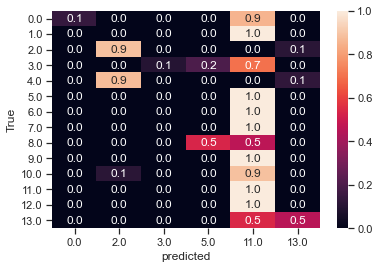

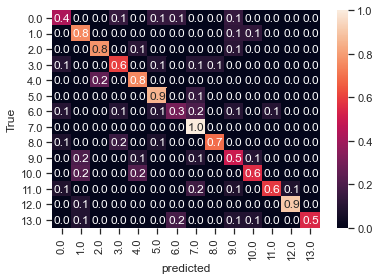

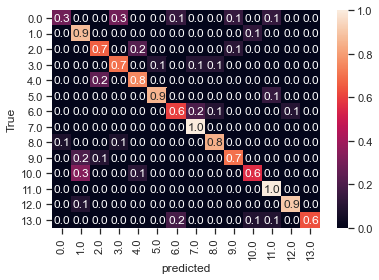

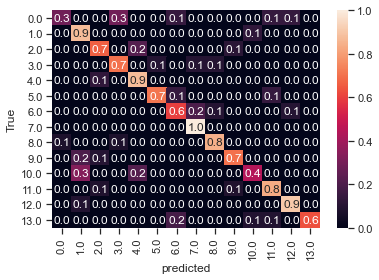

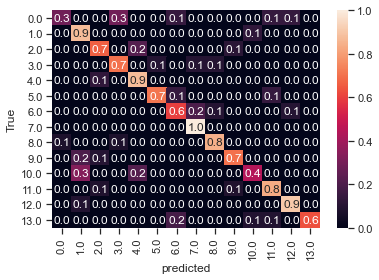

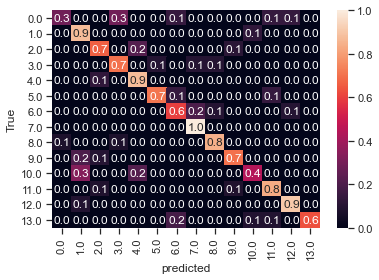

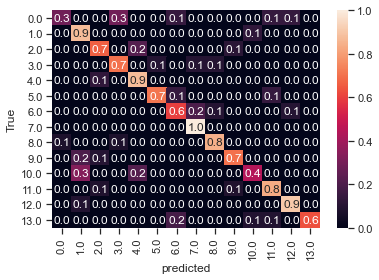

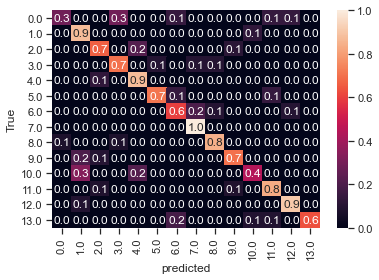

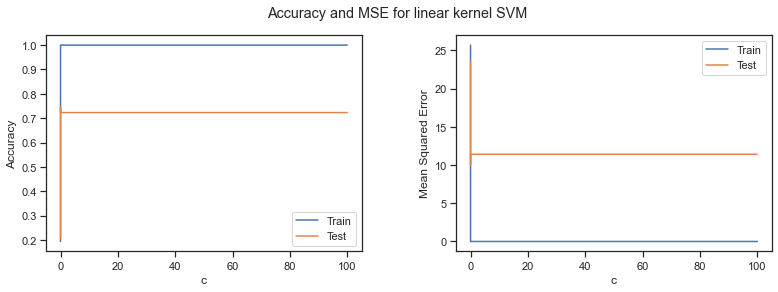

<Figure size 432x288 with 0 Axes>

In [21]:
svm_func('linear')

## Polynomial Kernel

Train Metrics: poly kernel SVM with c=1e-05
              precision    recall  f1-score   support

        Abra       0.00      0.00      0.00        28
   Bulbasaur       0.00      0.00      0.00        33
     Chansey       0.00      0.00      0.00        34
  Charmander       0.00      0.00      0.00        41
       Ditto       0.00      0.00      0.00        32
       Eevee       0.00      0.00      0.00        30
      Krabby       0.00      0.00      0.00        38
      Meowth       0.00      0.00      0.00        21
     Pikachu       0.00      0.00      0.00        49
     Poliwag       0.00      0.00      0.00        41
     Porygon       0.00      0.00      0.00        37
     Snorlax       0.09      1.00      0.17        47
    Squirtle       0.00      0.00      0.00        41
     Voltorb       0.00      0.00      0.00        44

    accuracy                           0.09       516
   macro avg       0.01      0.07      0.01       516
weighted avg       0.01      0.09   

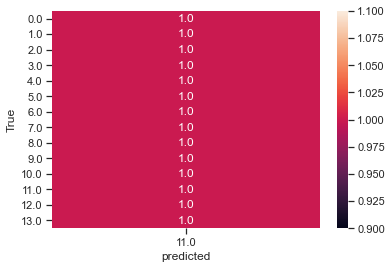

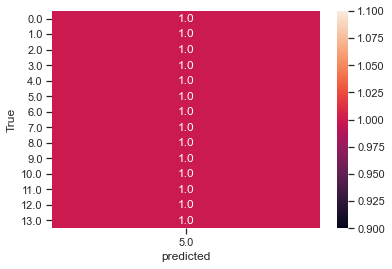

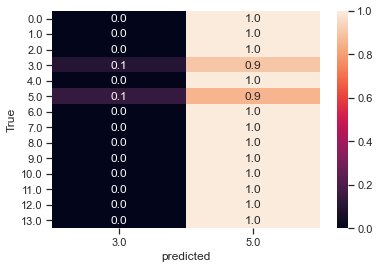

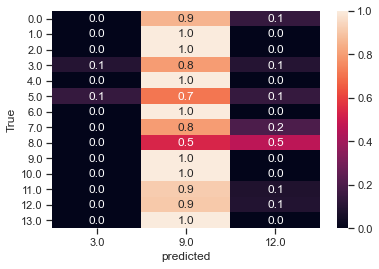

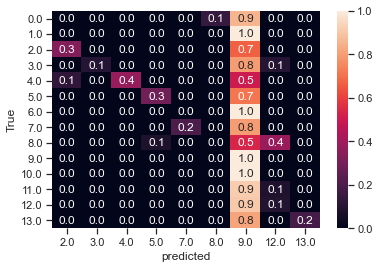

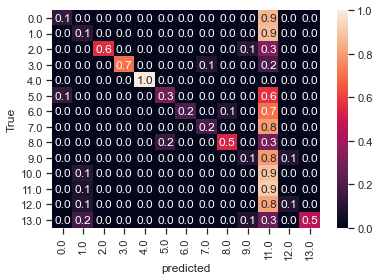

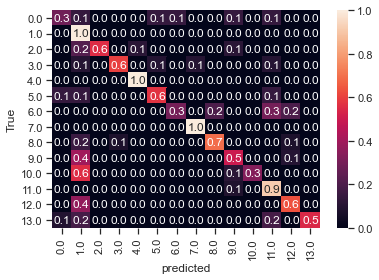

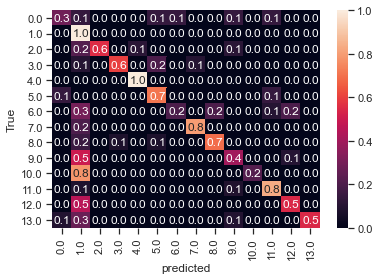

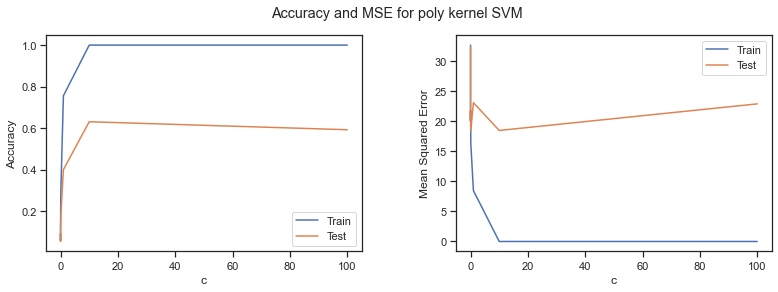

<Figure size 432x288 with 0 Axes>

In [22]:
svm_func('poly')

## RBF Kernel

Train Metrics: rbf kernel SVM with c=1e-05
              precision    recall  f1-score   support

        Abra       0.00      0.00      0.00        28
   Bulbasaur       0.00      0.00      0.00        33
     Chansey       0.00      0.00      0.00        34
  Charmander       0.00      0.00      0.00        41
       Ditto       0.00      0.00      0.00        32
       Eevee       0.00      0.00      0.00        30
      Krabby       0.00      0.00      0.00        38
      Meowth       0.00      0.00      0.00        21
     Pikachu       0.00      0.00      0.00        49
     Poliwag       0.00      0.00      0.00        41
     Porygon       0.00      0.00      0.00        37
     Snorlax       0.09      1.00      0.17        47
    Squirtle       0.00      0.00      0.00        41
     Voltorb       0.00      0.00      0.00        44

    accuracy                           0.09       516
   macro avg       0.01      0.07      0.01       516
weighted avg       0.01      0.09    

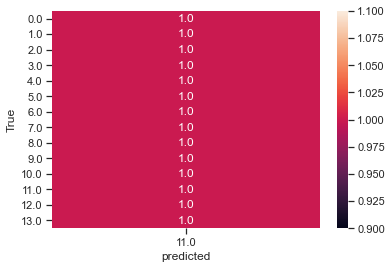

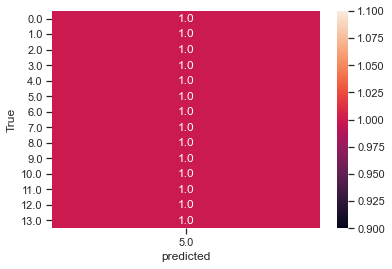

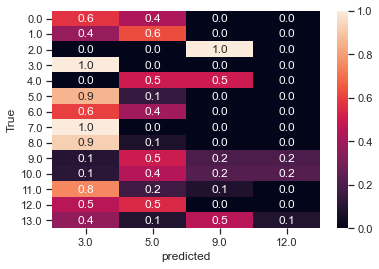

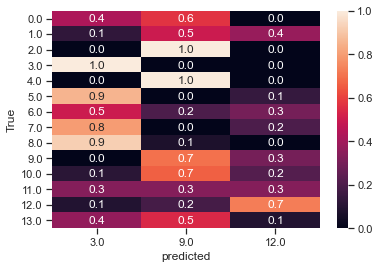

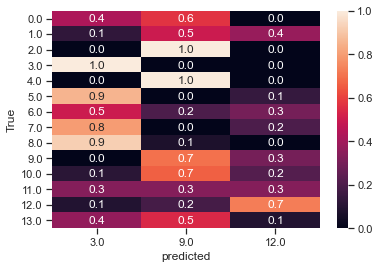

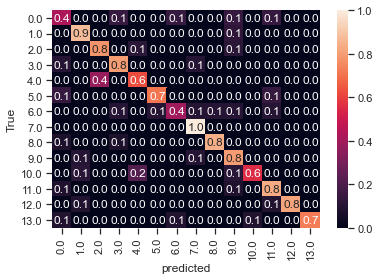

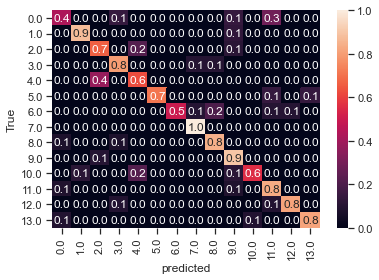

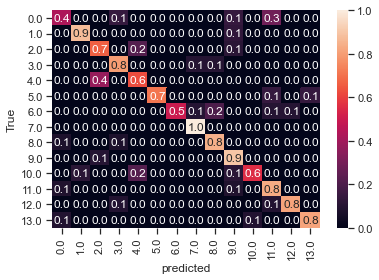

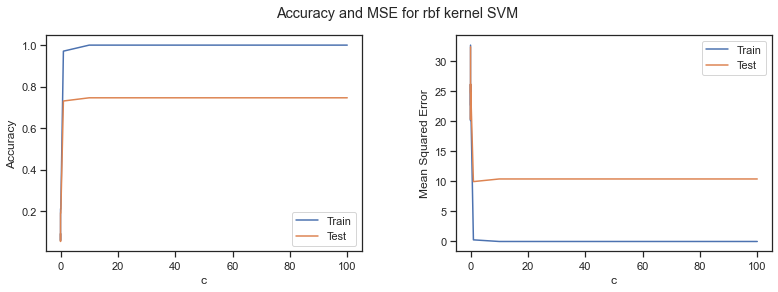

<Figure size 432x288 with 0 Axes>

In [23]:
svm_func('rbf')

# Section 4: Neural Networks

In [24]:
image_path = 'NN'
try:
    os.mkdir(image_path)
except FileExistsError:
    pass

## Function to process and display neural networks of varying alpha

In [37]:
def run_nn(nn_structure,scaling='standard',max_iter=5000,learning_rate=0.001, activation='relu'):
    X_train, X_test, y_train, y_test = scale_split_data(X, y, scaling=scaling)
    y_train_1d = y_train.reshape(y_train.size)
    y_test_1d = y_test.reshape(y_test.size)

    name_mod = '('+','.join([str(i) for i in nn_structure])+')'
    file_mod = name_mod + '_' + activation
    title_mod = 'nn structure: ' + name_mod + ', ' + activation + ' activation'


    table_data = []
    table_row_labels=[]
    
    # alpha_vals = [0] + [10**i for i in range(-5,3)]
    alpha_vals=[0.1]
    for alpha in alpha_vals:
        nn = MLPClassifier(hidden_layer_sizes=nn_structure[1:len(nn_structure)-1], activation=activation, alpha=alpha,learning_rate_init=learning_rate, max_iter=max_iter, random_state=35)
        nn.fit(X_train, y_train)
        
        y_hat_train  = nn.predict(X_train)
        y_hat_test  = nn.predict(X_test)
        acc_train = nn.score(X_train, y_train)
        acc_test = nn.score(X_test, y_test)
        table_data.append([acc_train, acc_test, mse(y_train, y_hat_train), mse(y_test, y_hat_test)])
        print(y_hat_train.shape)
        label=" alpha = {}".format(alpha)
        table_row_labels.append(label)
        print('Train Metrics: NN {}with '.format(title_mod)+ label )
        print(metrics.classification_report(y_train, y_hat_train, target_names=poke_labels))
        print('Test Metrics: NN {} with '.format(title_mod)+label)
        print(metrics.classification_report(y_test, y_hat_test, target_names=poke_labels))
        # heatmap from https://medium.com/swlh/logistic-regression-for-image-classification-e15d0ae59ce9
        cm = pd.crosstab(y_test_1d, y_hat_test, rownames=["True"], colnames=["predicted"], normalize='index')
        p = sns.heatmap(cm, annot=True, fmt=".1f")
        plt.show()

#         print('Train Accuracy = {0:f}(%)'.format(acc_train*100))
#         print('Test Accuracy = {0:f}(%)'.format(acc_test*100))

    # plots
    array_data = np.array(table_data)      

    # Plot accuracy and MSE
    fig, axs = plt.subplots(1,2, figsize=(13,5))
    fig.suptitle("Accuracy and MSE for {}".format(title_mod))
    plt.legend(labels=['Train', 'Test'], ncol=2, bbox_to_anchor=(0.7,0.95) )

    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Mean Squared Error")
    for col in range(axs.shape[0]):
        axs[col].plot(alpha_vals, array_data[:, col*2])
        axs[col].plot(alpha_vals, array_data[:, col*2+1])
        axs[col].set_xlabel('alpha')
        axs[col].legend(['Train', 'Test'], bbox_to_anchor=(0.7,0.95) )

    fig.subplots_adjust(wspace=0.3,hspace=0.4,top=0.9, bottom=0.3)

    fig.savefig(image_path+"/nn_acc_mse_{}.png".format(file_mod))
    plt.show()
    plt.clf()

In [34]:
def run_all_nn(nn_structure,scaling='standard',max_iter=5000,learning_rate=0.001):
    # logistic/sigmoid
    # run_nn(nn_structure,activation='logistic',scaling=scaling, max_iter=max_iter, learning_rate=learning_rate)
    # relu
    run_nn(nn_structure,activation='relu',scaling=scaling, max_iter=max_iter, learning_rate=learning_rate)
    # tanh
    # run_nn(nn_structure,activation='tanh',scaling=scaling, max_iter=max_iter, learning_rate=learning_rate)

## 1-layer Neural Network

In [27]:
nn_structure = [4800, 210, 14]

(516,)
Train Metrics: NN nn structure: (4800,210,14), logistic activationwith  alpha = 0
              precision    recall  f1-score   support

        Abra       1.00      1.00      1.00        28
   Bulbasaur       1.00      1.00      1.00        33
     Chansey       1.00      1.00      1.00        34
  Charmander       1.00      1.00      1.00        41
       Ditto       1.00      1.00      1.00        32
       Eevee       1.00      1.00      1.00        30
      Krabby       1.00      1.00      1.00        38
      Meowth       1.00      1.00      1.00        21
     Pikachu       1.00      1.00      1.00        49
     Poliwag       1.00      1.00      1.00        41
     Porygon       1.00      1.00      1.00        37
     Snorlax       1.00      1.00      1.00        47
    Squirtle       1.00      1.00      1.00        41
     Voltorb       1.00      1.00      1.00        44

    accuracy                           1.00       516
   macro avg       1.00      1.00      1.00  

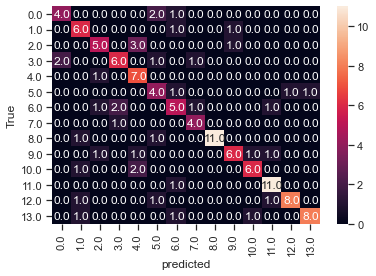

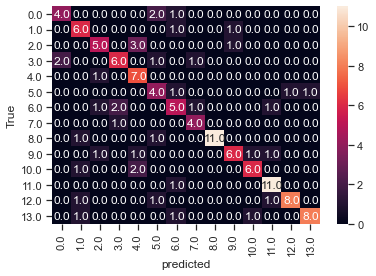

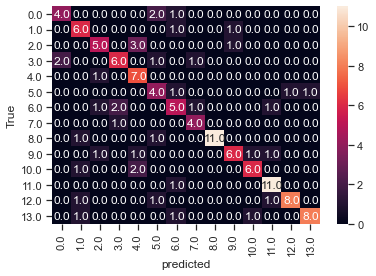

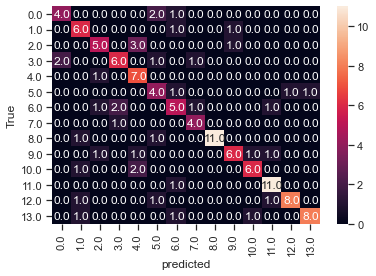

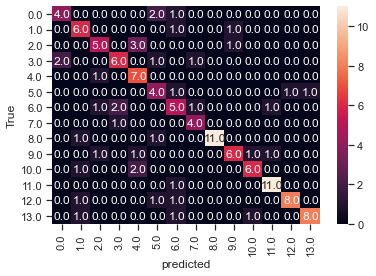

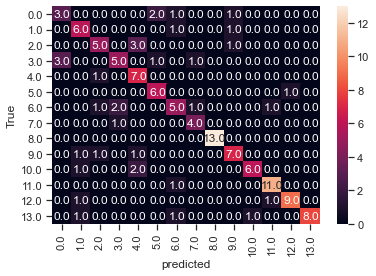

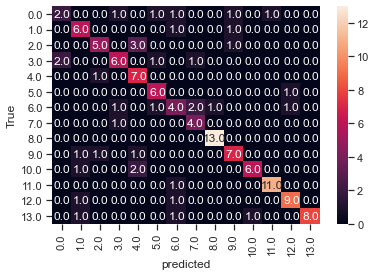

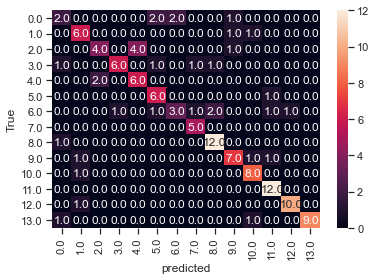

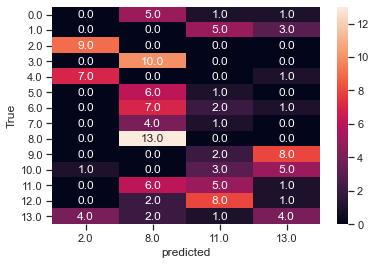

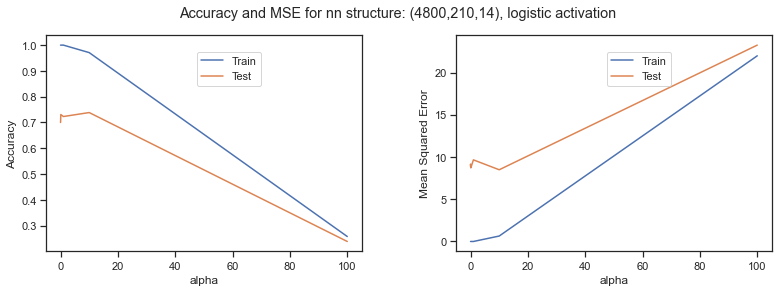

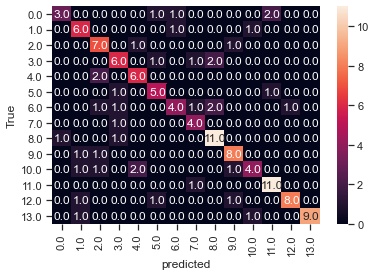

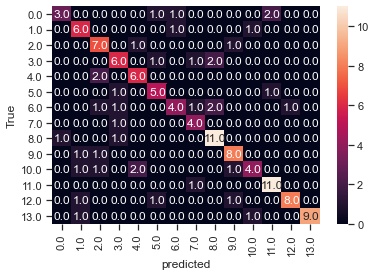

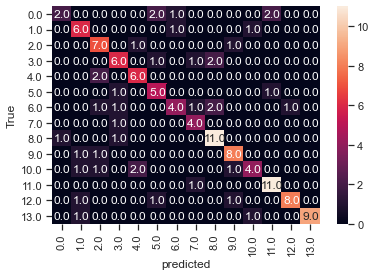

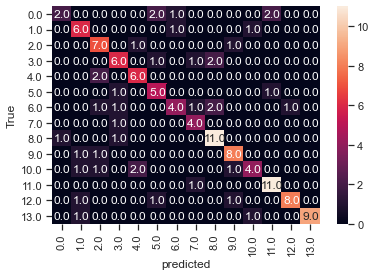

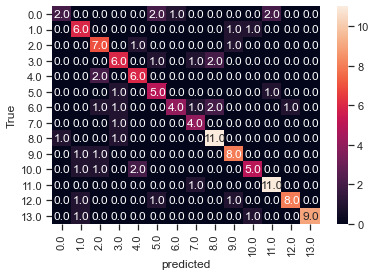

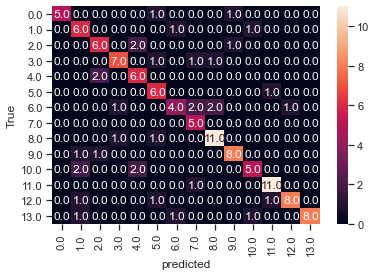

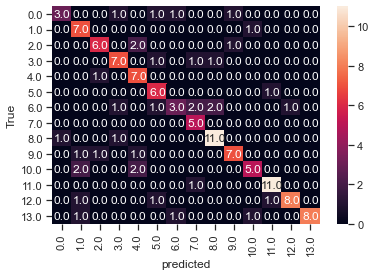

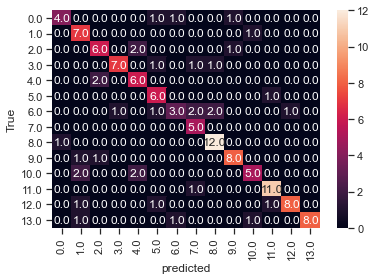

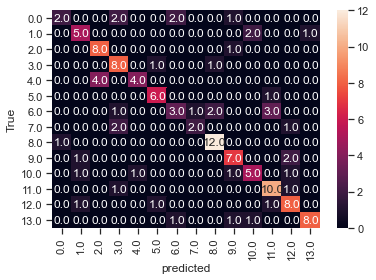

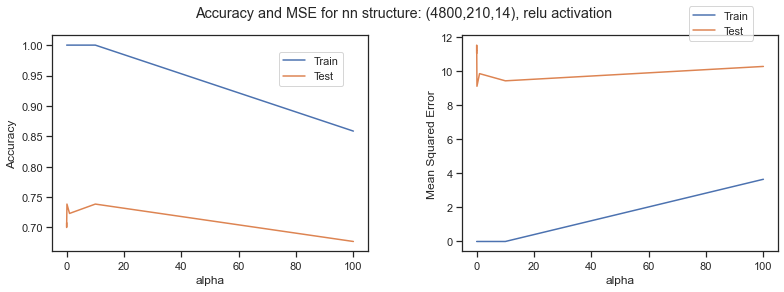

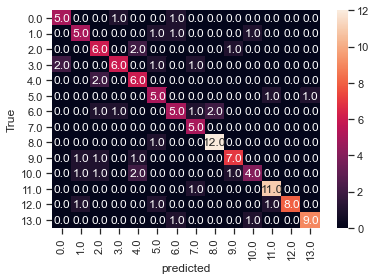

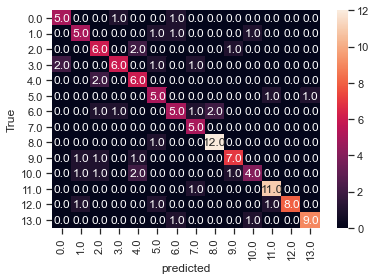

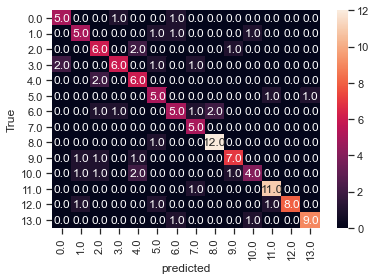

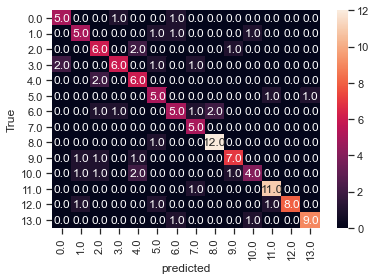

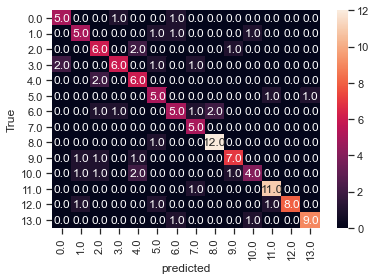

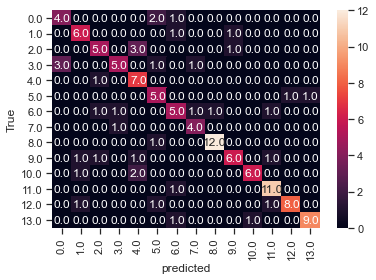

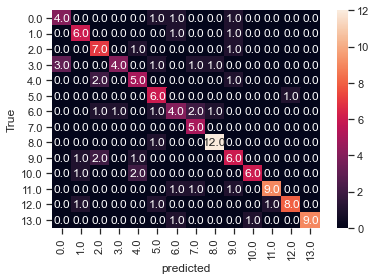

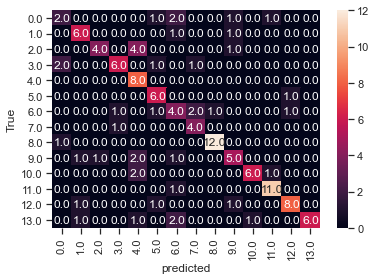

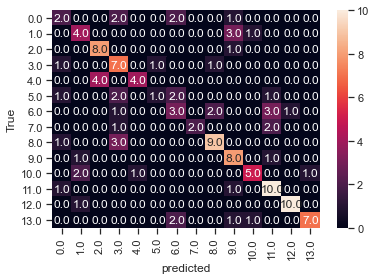

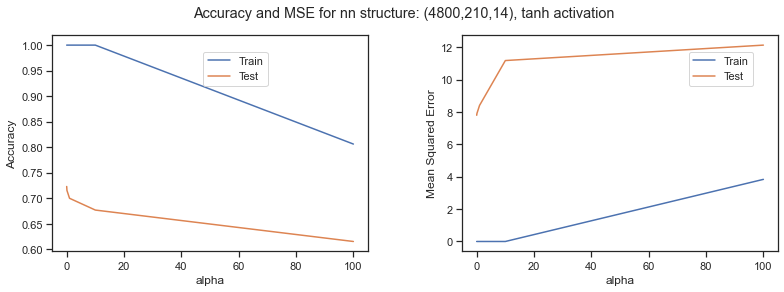

<Figure size 432x288 with 0 Axes>

In [28]:
run_all_nn(nn_structure)


## 2-layer Neural Network

In [35]:
nn_structure = [4800, 85, 324, 14]


(516,)
Train Metrics: NN nn structure: (4800,85,324,14), relu activationwith  alpha = 0.1
              precision    recall  f1-score   support

        Abra       1.00      1.00      1.00        28
   Bulbasaur       1.00      1.00      1.00        33
     Chansey       1.00      1.00      1.00        34
  Charmander       1.00      1.00      1.00        41
       Ditto       1.00      1.00      1.00        32
       Eevee       1.00      1.00      1.00        30
      Krabby       1.00      1.00      1.00        38
      Meowth       1.00      1.00      1.00        21
     Pikachu       1.00      1.00      1.00        49
     Poliwag       1.00      1.00      1.00        41
     Porygon       1.00      1.00      1.00        37
     Snorlax       1.00      1.00      1.00        47
    Squirtle       1.00      1.00      1.00        41
     Voltorb       1.00      1.00      1.00        44

    accuracy                           1.00       516
   macro avg       1.00      1.00      1.00 

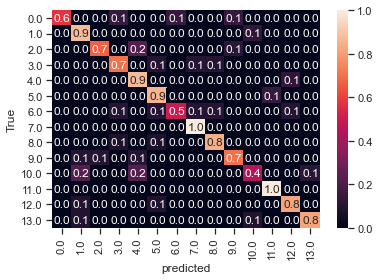

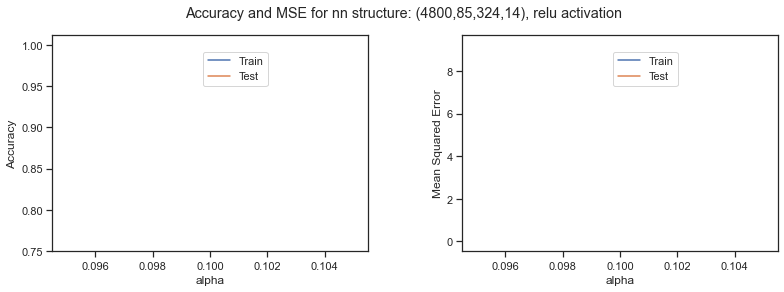

<Figure size 432x288 with 0 Axes>

In [38]:
run_all_nn(nn_structure)
